<a href="https://colab.research.google.com/github/benson85560/yuanta/blob/main/Dividend_Yield_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
from pandas.core.tools.datetimes import to_datetime


path = os.getcwd()
print(path)

/content


In [2]:
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
#Colab安裝Talib
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

--2022-08-03 23:59:36--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-08-03 23:59:36--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://cytranet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-08-03 23:59:37--  http://cytranet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving cytranet.dl.s

In [4]:
import talib 
from talib import abstract

## 抓取資料

In [322]:
# symbol_list = ['0050.TW','0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
#                '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW', '00728.TW', 
#                '00730.TW', '00731.TW', '00733.TW', '00735.TW']
# for i in range(len(symbol_list)):
symbol = '0050.TW'

data = yf.Ticker(symbol)
df = data.history(period='D', start='2008-1-1', end='2022-6-30')
# fifty.to_csv(path+'/0050.csv')
# df_0050 = pd.read_csv(path+'/0050.csv')
# df_0050 = df_0050.set_index(pd.to_datetime(df_0050['Date']))
# df_0050 = df_0050.drop('Date', axis = 1)
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['date']))
Yield = Yield.drop('date', axis = 1)
df = pd.concat([df,Yield], join='outer', axis=1)
df.head(5)

,open,high,low,close,volume,0050,0051,0052,0053,0055,...,00701,00712,00713,00714,00717,00728,00730,00731,00733,00735
2008-01-02,60.009998,60.009998,60.009998,60.009998,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-03,58.889999,58.889999,58.889999,58.889999,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-04,59.009998,59.009998,59.009998,59.009998,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-07,56.389999,56.389999,56.389999,56.389999,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-08,56.980000,56.980000,56.980000,56.980000,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [304]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'EMA', 'MACD', 'SAR', '0050',
       '0051', '0052', '0053', '0055', '0056', '006203', '006204', '006208',
       '00690', '00692', '00701', '00712', '00713', '00714', '00717', '00728',
       '00730', '00731', '00733', '00735', '0050', '0051', '0052', '0053',
       '0055', '0056', '006203', '006204', '006208', '00690', '00692', '00701',
       '00712', '00713', '00714', '00717', '00728', '00730', '00731', '00733',
       '00735'],
      dtype='object')

In [291]:
df['EMA'] = abstract.EMA(df, timeperiod = 200)
df['MACD'] = abstract.MACD(df, fastperiod=12, slowperiod=26, signalperiod=9)['macd']
df['SAR'] = abstract.SAR(df)
df

,open,high,low,close,volume,EMA,MACD,SAR
Date,,,,,,,,
2018-04-12,50.000000,50.000000,50.000000,50.000000,0,NaN,NaN,NaN
2018-04-13,49.980000,49.980000,49.980000,49.980000,0,NaN,NaN,50.000000
2018-04-16,49.950001,49.950001,49.950001,49.950001,0,NaN,NaN,49.999600
2018-04-17,49.740002,49.740002,49.740002,49.740002,0,NaN,NaN,49.997616
2018-04-18,49.830002,49.830002,49.830002,49.830002,0,NaN,NaN,49.982159
...,...,...,...,...,...,...,...,...
2022-06-23,58.099998,58.200001,57.549999,57.900002,1193707,59.225993,-0.447414,58.295277
2022-06-24,58.299999,58.450001,58.150002,58.299999,1029215,59.216779,-0.391625,56.849998
2022-06-27,58.450001,58.799999,58.450001,58.750000,1045361,59.212134,-0.307556,56.881999


In [218]:
# # create dvd_yld payment day

# #-----# : 0050
# d = pd.DataFrame({'yield' : [3.3, 1.22, 2.3, 0.85, 2.5, 0.83, 3.01, 0.85, 3.15, 0.72, 2.13, 0.26, 2.15], 
#                    'date' : pd.to_datetime(['2015-10-26', '2016-7-28', '2017-2-8', '2017-7-31', '2018-1-29', '2018-7-23', '2019-1-22',
#                                             '2019-7-19', '2020-1-31', '2020-7-21', '2021-1-22', '2021-7-21', '2022-1-21'])})
# #-----# : 006208
# # d = pd.DataFrame({'yield' : [1.0, 1.65, 0.65, 2, 0.66, 1.14, 0.48, 1.14, 0.31, 1.64],
# #                     'date' : pd.to_datetime(['2017-7-27', '2017-11-30', '2018-7-26', '2018-11-29', '2019-7-18', '2019-11-20','2020-7-21', '2020-11-17', '2021-7-16',
# #                                              '2021-11-16'])})

# d = d.set_index(d['date'])
# d = d.drop('date', axis = 1)
# yld = d

In [292]:
Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['date']))
Yield = Yield.drop('date', axis = 1)
Yield

,0050,0051,0052,0053,0055,0056,006203,006204,006208,00690,...,00701,00712,00713,00714,00717,00728,00730,00731,00733,00735
date,,,,,,,,,,,,,,,,,,,,,
2009-10-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-10-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-10-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-10-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-10-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [300]:
# comfirming each day is matched with 0050
# pd.merge(df,yld, how='inner', left_index=True, right_index=True)
df = pd.concat([df,Yield], join='outer', axis=1)

## Strategy

主要策略 => 息收前後進場
1. 除息日前 x 天進場，前 y 天出場
2. 除昔日後 z 天進場，(等回補出場)



In [209]:

# initial setting

fund = 100 #初始有100元本金
money = 100 #每次投入
feeRate = 0.003 #手續費

               profit
2009-10-13   0.000000
2009-10-14   0.000000
2009-10-15   0.000000
2009-10-16   0.000000
2009-10-19   0.000000
...               ...
2022-06-22  12.615282
2022-06-23  12.615282
2022-06-24  12.615282
2022-06-27  12.615282
2022-06-28  12.615282

[3127 rows x 1 columns]


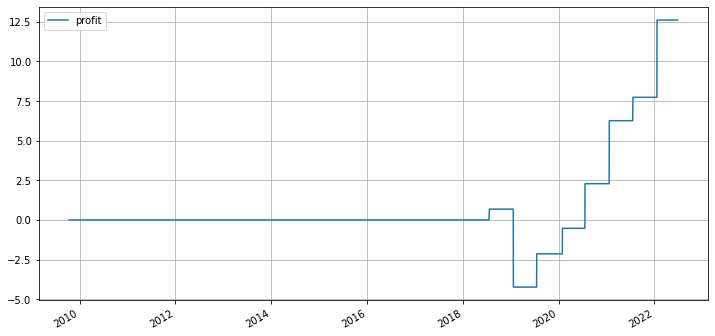

In [294]:
# 主要策略

profit_list = []
price = []
buy = []
# buy2 = []
sell = []
# sell2 = []
open_price = []
position = "A"
timeList = []

for i in range(len(df)):

    if i == len(df)-1:
      break
    
    if df['0050'][i] > 0 and df['close'][i] > 0: # 除息日
        tempSize = money / df['close'][i-30] # 前 15 天進場
        buy.append(i-30)
  
        profit = tempSize * (df['close'][i-5] - df['close'][i-30]) # 前 5 天出場並計算報酬
        sell.append(i-5)
        profit_list.append(profit)
        timeList.append(df.index[i]) 

        # temp2 = money / df['Open'][i+1] # 除息隔天進場
        # buy2.append(i+1)
        # price.append(df['close'][i-1]) # 除息日前一天收盤價
        # open_price.append(df['Open'][i+1]) # 進場開盤價
        # position = "B"

        
    # elif position == "B" and df['close'][i] >= price[-1]:   # 若除息日後仍有部位且收盤價大於當時買入價 => 隔天開盤回補
    #     profit = temp2 * (df['close'][i] - open_price[-1])
    #     sell2.append(i)
    #     profit_list.append(profit)
    #     timeList.append(df.index[i]) 
    #     position = "A"

    # elif position == 'B' and (df['close'][i] - price[-1]) / df['close'][i] < -0.1 : # 停損：<-10%
    #     profit = temp2 * (df['close'][i] - open_price[-1])
    #     sell2.append(i)
    #     profit_list.append(profit)
    #     timeList.append(df.index[i]) 
    #     position = "A"

    else:
      profit_list.append(0)
      timeList.append(df.index[i])


# equity = pd.DataFrame({'profit':profit_list}, index=timeList)

equity = pd.DataFrame({'profit':np.cumsum(profit_list)}, index=timeList)
print(equity)
equity.plot(grid=True, figsize=(12, 6));

In [267]:
# 實際交易位置
print(buy)
print(sell)
# print(buy2)
# print(sell2)

[2023, 2137, 2265, 2380, 2507, 2623, 2752, 2868, 2996]
[2048, 2162, 2290, 2405, 2532, 2648, 2777, 2893, 3021]


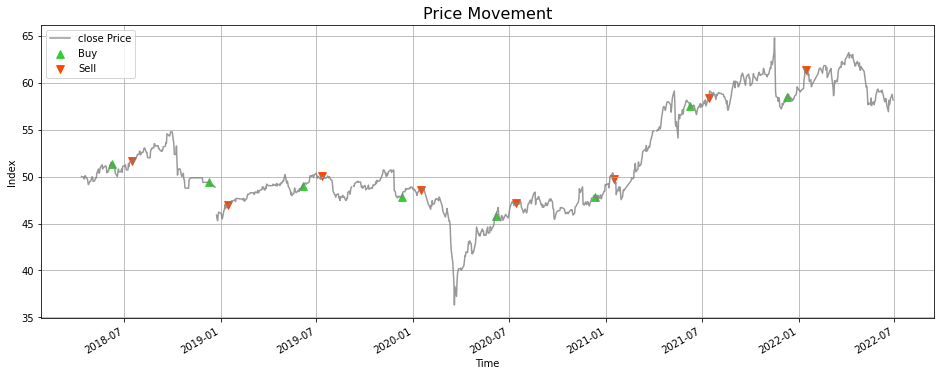

In [295]:
fig, ax = plt.subplots(figsize = (16,6))

df['close'].plot(label = 'close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'limegreen', label = 'Buy', marker='^', s=60)
plt.scatter(df['close'].iloc[sell].index, df['close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
# plt.scatter(df['close'].iloc[buy2].index, df['close'].iloc[buy2],c = 'y', label = 'Buy2', marker='^', s=60)
# plt.scatter(df['close'].iloc[sell2].index, df['close'].iloc[sell2],c = 'b', label = 'Sell2', marker='v', s=60)

plt.legend()
plt.ylabel('Index')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

In [296]:
equity['equity'] = equity['profit'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

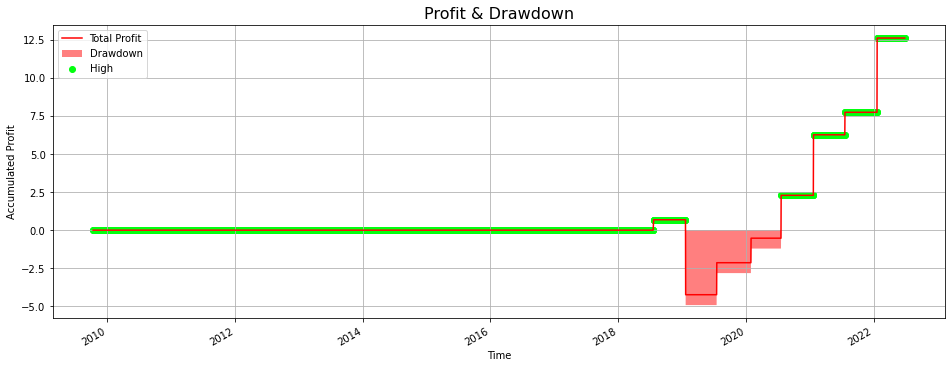

In [297]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profit'].cummax() == equity['profit']].index
equity['profit'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profit'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);

# 成網格狀是因為一次加總多天報酬

# 整合

In [ ]:
symbol_list = ['0050.TW','0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
               '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW', '00728.TW', 
               '00730.TW', '00731.TW', '00733.TW', '00735.TW']

for i in range(len(symbol_list)):
  symbol = symbol_list[i]

  data = yf.Ticker(symbol)
  df = data.history(period='D', start='2008-1-1', end='2022-6-30')
  df = df.drop(columns = ['Dividends', 'Stock Splits'])
  df.columns = ['open', 'high', 'low', 'close', 'volume']
  Yield = pd.read_csv(path + '/yield.csv')
  Yield = Yield.set_index(pd.to_datetime(Yield['date']))
  Yield = Yield.drop('date', axis = 1)
  df = pd.concat([df,Yield], join='outer', axis=1)

  # initial setting

  fund = 100 #初始有100元本金
  money = 100 #每次投入
  feeRate = 0.003 #手續費

  # 主要策略

  profit_list = []
  price = []
  buy = []
  sell = []
  open_price = []
  position = "A"
  timeList = []

  for i in range(len(df)):

      if i == len(df)-1:
        break
      
      if df['0050'][i] > 0 and df['close'][i] > 0: # 除息日
          tempSize = money / df['close'][i-30] # 前 15 天進場
          buy.append(i-30)
    
          profit = tempSize * (df['close'][i-5] - df['close'][i-30]) # 前 5 天出場並計算報酬
          sell.append(i-5)
          profit_list.append(profit)
          timeList.append(df.index[i]) 

          # temp2 = money / df['Open'][i+1] # 除息隔天進場
          # buy2.append(i+1)
          # price.append(df['close'][i-1]) # 除息日前一天收盤價
          # open_price.append(df['Open'][i+1]) # 進場開盤價
          # position = "B"

          
      # elif position == "B" and df['close'][i] >= price[-1]:   # 若除息日後仍有部位且收盤價大於當時買入價 => 隔天開盤回補
      #     profit = temp2 * (df['close'][i] - open_price[-1])
      #     sell2.append(i)
      #     profit_list.append(profit)
      #     timeList.append(df.index[i]) 
      #     position = "A"

      # elif position == 'B' and (df['close'][i] - price[-1]) / df['close'][i] < -0.1 : # 停損：<-10%
      #     profit = temp2 * (df['close'][i] - open_price[-1])
      #     sell2.append(i)
      #     profit_list.append(profit)
      #     timeList.append(df.index[i]) 
      #     position = "A"

      else:
        profit_list.append(0)
        timeList.append(df.index[i])

  equity = pd.DataFrame({'profit':np.cumsum(profit_list)}, index=timeList)
  print(equity)
  

### 新策略 => 僅針對趨勢
1. EMA : df['Close'] > EMA(200)
2. MACD : MACD > 0
3. SAR : SAR < df['Close'] 

* 停損 : stopLoss = df['Close'][i] - SAR[i]
* 停利 : = stopLoss

               profit  profitfee
2019-05-03   0.000000   0.000000
2019-05-09  -2.257744  -2.850971
2019-06-24  -1.005972  -2.202954
2019-07-29  -1.604773  -3.399959
2019-12-02  -5.121341  -7.505977
2020-08-17  -0.976259  -3.973330
2020-09-02  -3.359682  -6.949603
2020-09-24  -7.561363 -11.738679
2020-11-11  -4.098433  -8.886138
2021-01-11  -0.022295  -5.422228
2021-01-20  -4.085723 -10.073466
2021-03-03  -0.028399  -6.628314
2021-03-15   3.588411  -3.622354
2021-03-29   7.288602  -0.533263
2021-04-19  12.671816   4.233800
2021-05-13   9.016459  -0.010590
2021-09-14  14.591367   4.947592
2021-11-10  17.380539   7.128398
2021-11-16  16.414358   5.565115
2022-01-11  18.702491   7.246384
2022-03-08  15.664721   3.617726
2022-05-12   9.729759  -2.899431


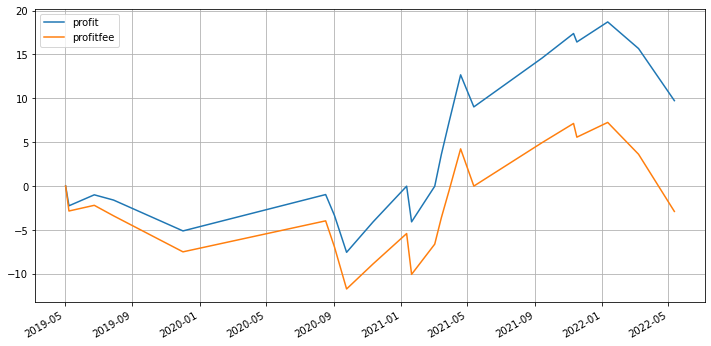

In [298]:
# 新策略

fund = 100 #初始有100元本金
money = 100 #每次投入100元
feeRate = 0.003
length = 40 # 均線長度
stdTimes = 2 # 標準差倍數
rule = '1H' # hour


first = 0 ##除了第一筆之外，只紀錄出場的時間點
BS = None ##紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0

#--------# 記錄買入、賣出時間點
buy = []
sell = []
sellshort = []
buytocover = []
# stopLoss = []
#--------# 
timeList = [] 
profit_list = [0]
profit_fee_list = [0]


for i in range(len(df)):

    if i == len(df)-1: # last trading day
        break
     
      # buy                                       # BS: position, B: buy, S: sell
    if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
        temp = df['open'][i+1] # 要加一 當看到訊號後的進場價
        tempSize = money / temp # 計算交易單位
        BS = 'B' # 做多
        t = i+1 
        buy.append(t)
        stopLoss = df['SAR'][i]
        stopEarn = df['close'][i] + (df['close'][i] - df['SAR'][i])
        # stopLoss.append(df['close'][i] - df['SAR'][i])

        
        if first == 0:
            timeList.append(df.index[i+1])
            first = 1
        continue

      # try 'buy' first 
      # sellshort
    # if df['close'][i] < df['EMA'][i] and df['MACD'][i] < 0 and df['close'][i] < df['SAR'][i] and BS == None:
    #     temp = df['open'][i+1]
    #     tempSize = money / temp
    #     BS = 'S'
    #     t = i+1
    #     sellshort.append(t)
        

    #     if first == 0:
    #         timeList.append(df.index[i+1])
    #         first = 1
    #     continue
        
      # buy停利
    if df['close'][i] > stopEarn and BS == 'B':
        profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

      # buy停損
    if df['close'][i] < stopLoss and BS == 'B':
        profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

       # buy to cover
    # if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
    #     profit = tempSize * (temp - df['open'][i+1])
    #     profit_fee = profit - money*feeRate - (money+profit)*feeRate
    #     profit_fee_list.append(profit_fee)
    #     profit_list.append(profit)
    #     buytocover.append(i+1)
    #     timeList.append(df.index[i])
    #     BS=None
    #     continue
    
    # 可加停利停損在這裡：if......
    

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=timeList)
print(equity)
equity.plot(grid=True, figsize=(12, 6));

[2356, 2388, 2393, 2449, 2625, 2674, 2695, 2729, 2733, 2775, 2794, 2804, 2812, 2822, 2835, 2862, 2939, 2977, 3013, 3020, 3059]
[2361, 2392, 2417, 2502, 2673, 2685, 2701, 2732, 2774, 2781, 2803, 2811, 2821, 2834, 2851, 2938, 2976, 2980, 3019, 3051, 3095]


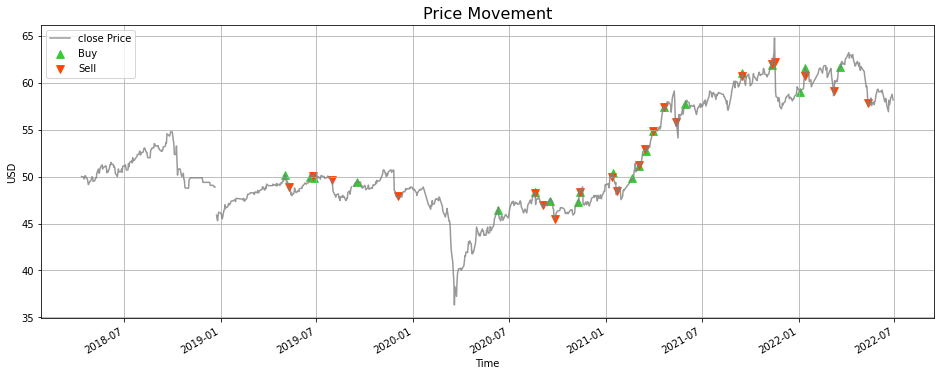

In [299]:
# 實際交易位置
print(buy)
print(sell)
fig, ax = plt.subplots(figsize = (16,6))

df['close'].plot(label = 'close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'limegreen', label = 'Buy', marker='^', s=60)
plt.scatter(df['close'].iloc[sell].index, df['close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
# plt.scatter(df['close'].iloc[buy2].index, df['close'].iloc[buy2],c = 'y', label = 'Buy2', marker='^', s=60)
# plt.scatter(df['close'].iloc[sell2].index, df['close'].iloc[sell2],c = 'b', label = 'Sell2', marker='v', s=60)

plt.legend()
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

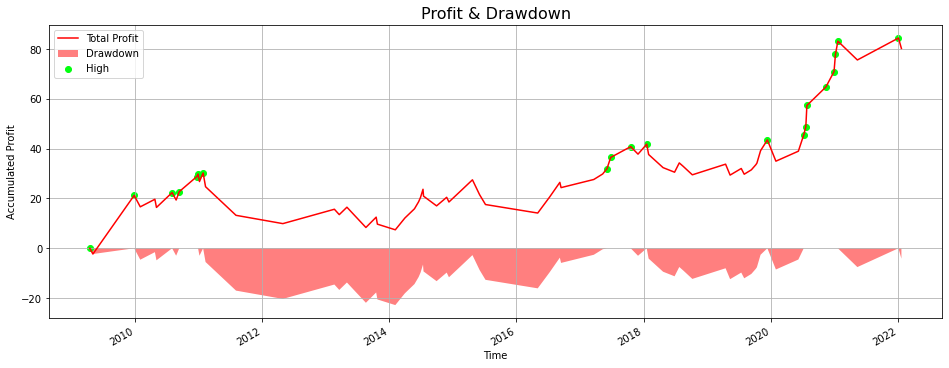

In [18]:
equity['equity'] = equity['profit'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profit'].cummax() == equity['profit']].index
equity['profit'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profit'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);


## Optimization

* 進場時間

In [19]:
df_in = df[:'2020-01']
df_out = df['2020-02':]

In [20]:
opt_list = []

fund = 100 #初始有100元本金
money = 100 #每次投入
feeRate = 0.003 #手續費

for In in range(10, 31):
  for Out in range(3, 10):
    
    print('----------')
    print(f'In: {In}')
    print(f'Out: {Out}')
  
    profit_list = []
    price = []
    buy = []
    buy2 = []
    sell = []
    sell2 = []
    open_price = []
    position = "A"
    timeList = []

    for i in range(len(df_in)):

        if i == len(df_in)-1:
          break
        
        if df_in['yield'][i] > 0 : # 除息日
            tempSize = money / df_in['close'][i-In] # 前 15 天進場
            buy.append(i-In)
      
            profit = tempSize * (df_in['close'][i-Out] - df_in['close'][i-In]) # 前 5 天出場並計算報酬
            sell.append(i-Out)
            profit_list.append(profit)
            timeList.append(df_in.index[i]) 

            # temp2 = money / df_in['Open'][i+1] # 除息隔天進場
            # buy2.append(i+1)
            # price.append(df_in['close'][i-1]) # 除息日前一天收盤價
            # open_price.append(df_in['Open'][i+1]) # 進場開盤價
            # position = "B"

            
        # elif position == "B" and df_in['close'][i] >= price[-1]:   # 若除息日後仍有部位且收盤價大於當時買入價 => 隔天開盤回補
        #     profit = temp2 * (df_in['close'][i] - open_price[-1])
        #     sell2.append(i)
        #     profit_list.append(profit)
        #     timeList.append(df_in.index[i]) 
        #     position = "A"

        # elif position == 'B' and (df_in['close'][i] - price[-1]) / df_in['close'][i] < -0.1 : # 停損：<-10%
        #     profit = temp2 * (df_in['close'][i] - open_price[-1])
        #     sell2.append(i)
        #     profit_list.append(profit)
        #     timeList.append(df_in.index[i]) 
        #     position = "A"

        else:
          profit_list.append(0)
          timeList.append(df_in.index[i])


    equity = pd.DataFrame({'profit':np.cumsum(profit_list)}, index=timeList)
    equity['equity'] = equity['profit'] + fund
    ret = equity['equity'][-1]/equity['equity'][0] - 1

    opt_list.append([In, Out, ret])

----------
In: 10
Out: 3
----------
In: 10
Out: 4
----------
In: 10
Out: 5
----------
In: 10
Out: 6
----------
In: 10
Out: 7
----------
In: 10
Out: 8
----------
In: 10
Out: 9
----------
In: 11
Out: 3
----------
In: 11
Out: 4
----------
In: 11
Out: 5
----------
In: 11
Out: 6
----------
In: 11
Out: 7
----------
In: 11
Out: 8
----------
In: 11
Out: 9
----------
In: 12
Out: 3
----------
In: 12
Out: 4
----------
In: 12
Out: 5
----------
In: 12
Out: 6
----------
In: 12
Out: 7
----------
In: 12
Out: 8
----------
In: 12
Out: 9
----------
In: 13
Out: 3
----------
In: 13
Out: 4
----------
In: 13
Out: 5
----------
In: 13
Out: 6
----------
In: 13
Out: 7
----------
In: 13
Out: 8
----------
In: 13
Out: 9
----------
In: 14
Out: 3
----------
In: 14
Out: 4
----------
In: 14
Out: 5
----------
In: 14
Out: 6
----------
In: 14
Out: 7
----------
In: 14
Out: 8
----------
In: 14
Out: 9
----------
In: 15
Out: 3
----------
In: 15
Out: 4
----------
In: 15
Out: 5
----------
In: 15
Out: 6
----------
In: 15
Out: 7


In [21]:
optResult = pd.DataFrame(opt_list, columns=['In','Out','return'])
optResult.sort_values('return', ascending = False).iloc[:5]

,In,Out,return
142,30,5,0.362751
141,30,4,0.358477
93,23,5,0.338214
140,30,3,0.336558
92,23,4,0.333761


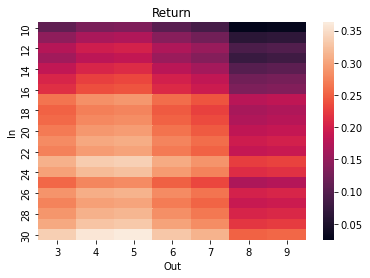

In [22]:
pic = optResult.pivot('In', 'Out', 'return') # 先整理資料格式
sns.heatmap(data = pic).set(title='Return');

## Final solution:
* 前 30 天進場
* 前 4 天出場

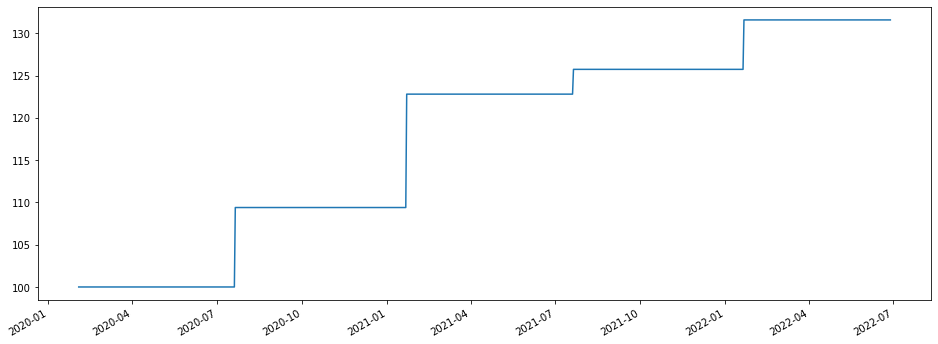

In [24]:
fund = 100 #初始有100元本金
money = 100 #每次投入
feeRate = 0.003 #手續費
In = 30
Out = 5

profit_list = []
price = []
buy = []
buy2 = []
sell = []
sell2 = []
open_price = []
position = "A"
timeList = []

for i in range(len(df_out)):

    if i == len(df_out)-1:
      break
    
    if df_out['yield'][i] > 0 : # 除息日
        tempSize = money / df_out['close'][i-In] # 前 15 天進場
        buy.append(i-In)
  
        profit = tempSize * (df_out['close'][i-Out] - df_out['close'][i-In]) # 前 5 天出場並計算報酬
        sell.append(i-Out)
        profit_list.append(profit)
        timeList.append(df_out.index[i]) 

        # temp2 = money / df_out['Open'][i+1] # 除息隔天進場
        # buy2.append(i+1)
        # price.append(df_out['close'][i-1]) # 除息日前一天收盤價
        # open_price.append(df_out['Open'][i+1]) # 進場開盤價
        # position = "B"

        
    # elif position == "B" and df_out['close'][i] >= price[-1]:   # 若除息日後仍有部位且收盤價大於當時買入價 => 隔天開盤回補
    #     profit = temp2 * (df_out['close'][i] - open_price[-1])
    #     sell2.append(i)
    #     profit_list.append(profit)
    #     timeList.append(df_out.index[i]) 
    #     position = "A"

    # elif position == 'B' and (df_out['close'][i] - price[-1]) / df_out['close'][i] < -0.1 : # 停損：<-10%
    #     profit = temp2 * (df_out['close'][i] - open_price[-1])
    #     sell2.append(i)
    #     profit_list.append(profit)
    #     timeList.append(df_out.index[i]) 
    #     position = "A"

    else:
      profit_list.append(0)
      timeList.append(df_out.index[i])


equity = pd.DataFrame({'profit':np.cumsum(profit_list)}, index=timeList)
equity['equity'] = equity['profit'] + fund
ret = equity['equity'][-1]/equity['equity'][0] - 1
equity['equity'].plot(figsize = (16, 6))


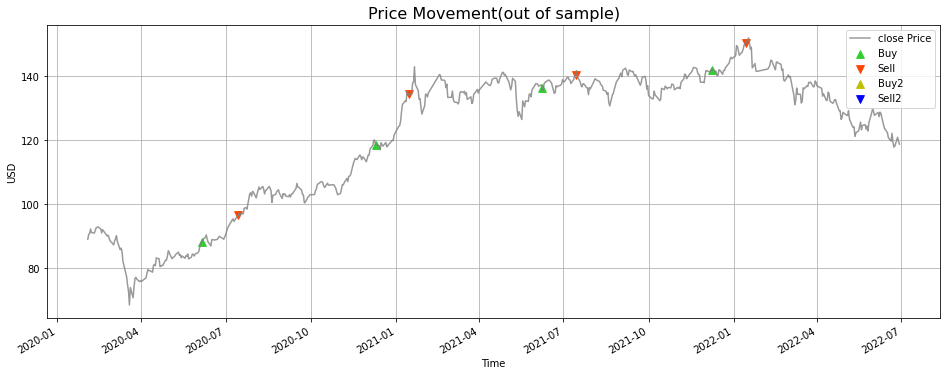

In [25]:
fig, ax = plt.subplots(figsize = (16,6))

df_out['close'].plot(label = 'close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(df_out['close'].iloc[buy].index, df_out['close'].iloc[buy],c = 'limegreen', label = 'Buy', marker='^', s=60)
plt.scatter(df_out['close'].iloc[sell].index, df_out['close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
plt.scatter(df_out['close'].iloc[buy2].index, df_out['close'].iloc[buy2],c = 'y', label = 'Buy2', marker='^', s=60)
plt.scatter(df_out['close'].iloc[sell2].index, df_out['close'].iloc[sell2],c = 'b', label = 'Sell2', marker='v', s=60)

plt.legend()
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Price Movement(out of sample)',fontsize  = 16);